# Setup

In [2]:
! pip install transformers newspaper3k

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 6.7 MB/s 
     |████████████████████████████████| 211 kB 50.9 MB/s 
     |████████████████████████████████| 182 kB 52.9 MB/s 
     |████████████████████████████████| 7.6 MB 44.1 MB/s 
     |████████████████████████████████| 7.4 MB 38.7 MB/s 
     |████████████████████████████████| 93 kB 2.5 MB/s 
     |████████████████████████████████| 81 kB 4.2 MB/s 
  Created wheel for tinysegmenter: filename=tinysegmenter-0.3-py3-none-any.whl size=13552 sha256=e1c1e28aee2b10d346f3c802fae0e52e4dea57dbfc6efe63d9273a1fbc42fac4
  Stored in directory: /root/.cache/pip/wheels/99/74/83/8fac1c8d9c648cfabebbbffe97a889f6624817f3aa0bbe6c09
  Created wheel for feedfinder2: filename=feedfinder2-0.0.4-py3-none-any.whl size=3354 sha256=5b8106b588fc6e37750cd556d598e1eb81e2f6f43464f0038c247b1eee412277
  Stored in directory: /root/.cache/pip/wheels/b6/09/68/a9f15498ac02c23d

In [3]:
# ! python -m spacy download en_core_web_sm

In [35]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
from tqdm import tqdm
from newspaper import Article
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from transformers import pipeline
from nltk.tokenize import word_tokenize
from nltk.stem.porter import *
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
MAIN_FOLDER = '/content/drive/MyDrive/url_classification/'
HTML_FOLDER = MAIN_FOLDER + 'html_files_Nov-24-2022/'
os.chdir(MAIN_FOLDER)

# Preprocessing

In [172]:
TARGET = 'label'
TEXT = 'text'
STOPWORDS = set(stopwords.words('english'))
nlp = spacy.load('en_core_web_sm')

In [8]:
# Constants that will disappear when transitioning to functions:
# Cell 1
html_folder = HTML_FOLDER
# Cell 2
csv_path = 'url_classification_temporary481.csv'
usecols = ['File Name', 'Label']

In [9]:
# Important cell # 1
html_files = os.listdir(html_folder)

In [10]:
# Important cell # 2

df = pd.read_csv(csv_path, usecols=usecols)
df.rename(columns={usecols[0]: 'filename', usecols[1]: 'label'}, inplace=True)
df = df[~df['filename'].isna()]
print(f'Original shape: {df.shape}')
df = df[df['label'] != '-']
df.reset_index(drop=True, inplace=True)
print(f'Final shape: {df.shape}')

Original shape: (480, 2)
Final shape: (410, 2)


In [11]:
# Important cell # 3
df[TARGET].value_counts(normalize=False)

Home Page        143
Blog              79
MISC              74
Product Page      41
Article           32
Event             15
White Paper       12
Education          6
?                  3
Press Release      2
Video Content      1
About Page         1
Publication        1
Name: label, dtype: int64

In [12]:
# Important cell # 4
filenames = df['filename'].values
htmls = list()

for i, filename in enumerate(filenames):
  try:
    with open(f'{HTML_FOLDER}{filename}') as f:
      html = f.read()
      htmls.append(html)
  except FileNotFoundError:
    print(f'File {i} not found: "{filename}"')

In [13]:
# Important cell # 5
toi_articles = list()

for html in htmls:
  toi_article = Article(url = ' ', language = "en")
  toi_article.set_html(html)
  toi_article.parse()
  toi_article.nlp()
  toi_articles.append(toi_article)

In [232]:
# Important cell # 6
y = df[TARGET].tolist()

In [233]:
# Important cell # 7
summaries = [(toi_article.title + '. ' + toi_article.text).replace('\n', ' ') for toi_article in toi_articles]

In [234]:
len(y), len(summaries)

(410, 410)

In [235]:
# Cell 8
minimum_words = 30 
maximum_classes = 4

# Important cell # 8
df_text = pd.DataFrame({TEXT: summaries, TARGET: y})

if minimum_words:
  df_text = df_text[df_text[TEXT].str.split().str.len() > minimum_words]

if maximum_classes:
  relevant_labels = df_text[TARGET].value_counts()[:maximum_classes].index
  df_text = df_text[df_text[TARGET].isin(relevant_labels)]
  
df_text.reset_index(drop=True, inplace=True)

In [236]:
df_text

,text,label
0,Write For Us. Want to Write for Us? Digital L...,MISC
1,"Write for Us. Yes, you. We’re always looking f...",MISC
2,FAQs for some new features available in the Be...,Blog
3,The Web Credibility Project. Our research in W...,Home Page
4,Model DJs for Retail. DJPeoples is the nation’...,MISC
...,...,...
293,Geniuz Media. The USPS is undoubtedly one of t...,Home Page
294,Submit Guest Post. Yes! We accept guest/Sponso...,MISC
295,Digital Marketing & Entrepreneurship Blog. Why...,MISC
296,"Real Estate, Fashion, Software, Travel. Write ...",MISC


In [237]:
# Cell 9
test_size = 0.2
random_state = 0

# Important cell # 8
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwords from text

    # nlp = load_nlp()
    # text = ' '.join(token.lemma_ for token in nlp(text))

    return text

print(f"Amount of words before cleaning text: {df_text[TEXT].apply(lambda x: len(x.split(' '))).sum()}")
df_text['cleaned_text'] = df_text[TEXT].apply(clean_text)
print(f"Amount of words after cleaning text: {df_text['cleaned_text'].apply(lambda x: len(x.split(' '))).sum()}")

Amount of words before cleaning text: 259791
Amount of words after cleaning text: 145773


In [238]:
def lemmatize_text(text):
    lemmatized = ' '.join(token.lemma_ for token in nlp(text))
    return lemmatized

print(f"Amount of words before lemmatizing text: {df_text[TEXT].apply(lambda x: len(x.split(' '))).sum()}")
df_text['lemmatized_text'] = df_text[TEXT].apply(lemmatize_text)
print(f"Amount of words after lemmatizing text: {df_text['lemmatized_text'].apply(lambda x: len(x.split(' '))).sum()}")

Amount of words before lemmatizing text: 259791
Amount of words after lemmatizing text: 313428


In [239]:
df_text

,text,label,cleaned_text,lemmatized_text
0,Write For Us. Want to Write for Us? Digital L...,MISC,write us want write us digital lamp one fastes...,write for we . want to write for we ? Digita...
1,"Write for Us. Yes, you. We’re always looking f...",MISC,write us yes always looking new authors youve ...,"write for we . yes , you . we ’re always look ..."
2,FAQs for some new features available in the Be...,Blog,faqs new features available beta wayback machi...,FAQs for some new feature available in the Bet...
3,The Web Credibility Project. Our research in W...,Home Page,web credibility project research web credibili...,the web Credibility Project . our research in ...
4,Model DJs for Retail. DJPeoples is the nation’...,MISC,model djs retail djpeoples nations premier age...,Model dj for Retail . djpeople be the nation ’...
...,...,...,...,...
293,Geniuz Media. The USPS is undoubtedly one of t...,Home Page,geniuz media usps undoubtedly one best courier...,Geniuz Media . the USPS be undoubtedly one of ...
294,Submit Guest Post. Yes! We accept guest/Sponso...,MISC,submit guest post yes accept guest sponsored p...,submit Guest Post . yes ! we accept guest / sp...
295,Digital Marketing & Entrepreneurship Blog. Why...,MISC,digital marketing entrepreneurship blog would ...,Digital Marketing & Entrepreneurship Blog . wh...
296,"Real Estate, Fashion, Software, Travel. Write ...",MISC,real estate fashion software travel write us g...,"real Estate , Fashion , Software , Travel . wr..."


In [156]:
df_text['lemmatized_text'].tolist()[10:30]

['Health , Fitness , Nutrition and Lifestyle Write for Us { Instant Approval } . ad Blocker DetectedOur website be make possible by display online advertisement to our visitor . please consider support we by disable your ad blocker .',
 'Maryland , Virginia , Web & Graphic Design , Digital Marketing Agency . serve the biomedical industry as innovator and educator , ABI spearhead the creation and manufacture of product instrumental to improve human diagnostic . HindSite Interactive provide design , development and maintenance include : site design and development ; e - commerce ; administration',
 'Element Index . if it apply to the body element , then it instead apply to the document as a whole . < /dd > < dt > article</dt > < dd > the article element represent a section of a page that consist of a composition that form an independent part of a document , page , or site . if it apply to the body element , then it instead apply to the document as a whole . \' ) ; < /script><section > < 

In [240]:
# Important cell # 9
column_used = 'lemmatized_text'

X = df_text[[column_used]]
y = df_text[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=test_size,
                                                    stratify=y, 
                                                    random_state=random_state)

In [241]:
# Important cell # 10
majority_class = y_train.value_counts().index[0]
baseline_accuracy = sum(y_test == majority_class) / len(y_test)
print(f'Baseline accuracy: {baseline_accuracy:.4f}')

Baseline accuracy: 0.3833


In [242]:
# Important cell # 11
vectorizer = TfidfVectorizer(ngram_range=(1, 3))
X_train_tr = vectorizer.fit_transform(X_train[column_used])
X_test_tr = vectorizer.transform(X_test[column_used])

In [243]:
X_train_tr.toarray().shape, X_test_tr.toarray().shape

((238, 240618), (60, 240618))

In [185]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [27]:
import string

# STOPWORDS = stop_words.ENGLISH_STOP_WORDS

#Function for basic cleaning/preprocessing texts
def clean(doc):
    # Removal of punctuation marks (.,/\][{} etc) and numbers
    doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
    # Removal of stopwords
    doc = " ".join([token for token in doc.split() if token not in STOPWORDS])
    return doc.lower()

# Modeling

In [28]:
def fit_model(clf, X_train_transformed, y_train):
  clf.fit(X_train_transformed, y_train)
  return clf

In [29]:
def predict(clf, X_test_transformed):
  y_pred = clf.predict(X_test_transformed)
  return y_pred

In [30]:
def get_accuracy(y_test, y_pred):
  accuracy = sum(y_pred == y_test) / len(y_test)
  return accuracy

In [31]:
def print_important_features(clf, features=5):
  """ 
  Get the most important features of a classifier when using a linear kernel (e.g. Logistic Regression, not SVM)
  """
  coef_importances = np.argsort(clf.coef_, axis=1)
  for i, class_ in enumerate(coef_importances[:, :features]):
      print(f'Class "{clf.classes_[i]}" - {features} most important features: '
            f'{vectorizer.get_feature_names_out()[class_]}')

In [123]:
def print_confusion_matrix(y_test, y_pred, with_report=False):
  ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
  plt.title(f'Confusion matrix - acc {get_accuracy(y_test, y_pred):.3f}', size=15)
  plt.show()
  if with_report:
    print('\n' + classification_report(y_test, y_pred))

In [50]:
def get_best_clf(clfs, X_train, X_test, y_train, y_test):
    results = []
    best_clf = None
    best_clf_name = None
    best_accuracy = 0

    for clf_name, clf in clfs:
        clf.fit(X_train, y_train)
        acc = clf.score(X_test, y_test) # accuracy score
        
        if acc > best_accuracy:
            best_accuracy = acc
            best_clf = clf
            best_clf_name = clf_name

        results.append({'clf': clf_name,
                        'accuracy': acc})
        
    print(pd.DataFrame(results).set_index('clf'))
    return best_clf, best_clf_name, best_accuracy

In [244]:
clfs = [
    ('LogisticRegression', LogisticRegression(max_iter=3000,
                                              class_weight='balanced')), 
    ('RandomForest', RandomForestClassifier(max_depth=18,
                                            n_estimators=75,
                                            random_state=0)), 
    ('KNN 15', KNeighborsClassifier(n_neighbors=15)),
    ('KNN 25', KNeighborsClassifier(n_neighbors=25)),
    ('KNN 35', KNeighborsClassifier(n_neighbors=35)),
    ('KNN 55', KNeighborsClassifier(n_neighbors=55)),
    ('KNN 75', KNeighborsClassifier(n_neighbors=75)),
    ('KNN 100', KNeighborsClassifier(n_neighbors=100)),
    ('SVM C1', SVC(C=1,
                   class_weight='balanced', 
                   random_state=0), ),
    ('MultinomialNB', MultinomialNB())
]

# clf, clf_name, val_acc = get_best_clf(clfs, X_train, X_test, y_train, y_test) # To use when I have more data for validation set
# print(f'Best classifier: {clf_name}, validation accuracy: {val_acc:.3f}, '
#       f'test accuracy: {clf.score(X_test, y_test):.3f}')

clf, clf_name, test_acc = get_best_clf(clfs, X_train_tr, X_test_tr, y_train, y_test)
print(f'Best classifier: {clf_name}, test accuracy: {test_acc:.3f}')

                    accuracy
clf                         
LogisticRegression  0.783333
RandomForest        0.700000
KNN 15              0.383333
KNN 25              0.350000
KNN 35              0.316667
KNN 55              0.300000
KNN 75              0.266667
KNN 100             0.266667
SVM C1              0.733333
MultinomialNB       0.433333
Best classifier: LogisticRegression, test accuracy: 0.783


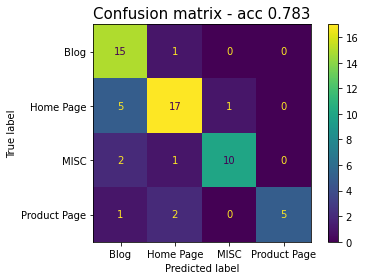


              precision    recall  f1-score   support

        Blog       0.65      0.94      0.77        16
   Home Page       0.81      0.74      0.77        23
        MISC       0.91      0.77      0.83        13
Product Page       1.00      0.62      0.77         8

    accuracy                           0.78        60
   macro avg       0.84      0.77      0.79        60
weighted avg       0.81      0.78      0.78        60



In [245]:
clf = fit_model(LogisticRegression(max_iter=3000, 
                                   class_weight='balanced'
                                   ), 
                X_train_tr, 
                y_train)

y_pred = predict(clf, X_test_tr)

print_confusion_matrix(y_test, y_pred, with_report=True)

In [246]:
y_pred[y_pred != y_test]

array(['Blog', 'Blog', 'Blog', 'Home Page', 'Blog', 'Home Page', 'Blog',
       'Home Page', 'Home Page', 'MISC', 'Blog', 'Blog', 'Blog'],
      dtype=object)

In [247]:
misclassified = y_test[y_pred != y_test]
misclassified

234            MISC
203       Home Page
235       Home Page
295            MISC
52        Home Page
26     Product Page
173       Home Page
212            Blog
42     Product Page
263       Home Page
201       Home Page
57     Product Page
163            MISC
Name: label, dtype: object

In [248]:
misclassified_df = X_test.copy()[y_pred != y_test]
misclassified_df['y_true'] = y_test[y_pred != y_test]
misclassified_df['y_pred'] = y_pred[y_pred != y_test]
misclassified_df

,lemmatized_text,y_true,y_pred
234,MIPA - DKIM . Home Deployment ietf WG FAQ m...,MISC,Blog
203,"Cryptonizor – know how to Store . Aug 1 , 2022...",Home Page,Blog
235,dmarc.org – Domain Message Authentication Repo...,Home Page,Blog
295,Digital Marketing & Entrepreneurship Blog . wh...,MISC,Home Page
52,"search listening tool for market , customer & ...",Home Page,Blog
26,AI Chatbot Software for Automated Customer Ser...,Product Page,Home Page
173,Content Analytics and Insights for Digital Pub...,Home Page,Blog
212,powerful api Stack for Data - drive seo Tools ...,Blog,Home Page
42,seo Toolbar by Ahrefs . what be Ahrefs seo Too...,Product Page,Home Page
263,Fearlessflyer.com . interested in writing for ...,Home Page,MISC


In [249]:
len(misclassified_df)

13

In [229]:
misclassified_df['lemmatized_text'].to_string()

"200    the CPD Certification Service - CPD Accreditat...\n223    COVID - Safe Policy , Procedures and Guideline...\n183    Content Strategy for Enterprise Marketers . Co...\n240    Website Accessibility Testing . I work in high...\n172    Content Analytics and Insights for Digital Pub...\n52     search listening tool for market , customer & ...\n121    10 Cliché marketing tagline we should all stop...\n262    Fearlessflyer.com . interested in writing for ...\n235    cPanel & WHM Documentation . add a redirectto ...\n253    redirection . Redirection be design to be use ...\n42     seo Toolbar by Ahrefs . what be Ahrefs seo Too...\n190    blogge 101 : the ABC 's of start a blog from s...\n74     Arubia Training . learn how to cost your servi...\n171    Link Building . it be still a thing ... but th...\n210    25 tip for Updating Old Blog Posts for seo & b...\n78     EU - US Privacy Shield . for example , custome...\n211    powerful api Stack for Data - drive seo Tools ...\n61     Bold S

In [228]:
misclassified_df['lemmatized_text'].tolist()

['the CPD Certification Service - CPD Accreditation . Malcolm Forbes"The capacity to learn be a gift ; the ability to learn be a skill ; the willingness to learn be a choice . " paulo coelho"education be not preparation ; education be life itself . " John Dewey"It ’s take I all my life to learn what not to play . " Johann Sebastian Bach"A man , though wise , should never be ashamed of learn more , and must unbend his mind . " R. Buckminster Fuller"It be the art of an educate mind to be able to entertain a thought without accept it . "',
 "COVID - Safe Policy , Procedures and Guidelines . at DigiMarCon conference we have more networking break on our program than other . XPremium Comfortable Meeting Spaces at DigiMarCon Conferences you be never ' leave in the dark ' … . additionally , on top of time - limit discount pass rate , because budget be tight , we want to make sure all group have a chance to attend DigiMarCon . DigiMarCon Conferences tap into the talent of the room , draw from t

In [203]:
y_pred

array(['Home Page', 'MISC', 'Home Page', 'Blog', 'Home Page', 'Blog',
       'Blog', 'Home Page', 'MISC', 'Home Page', 'Product Page', 'Blog',
       'Home Page', 'Home Page', 'Product Page', 'Blog', 'Blog', 'Blog',
       'Home Page', 'Blog', 'Home Page', 'Home Page', 'Home Page', 'Blog',
       'Blog', 'MISC', 'MISC', 'Home Page', 'Home Page', 'Blog',
       'Product Page', 'Blog', 'MISC', 'Blog', 'Blog', 'Home Page',
       'MISC', 'Blog', 'Blog', 'Home Page', 'Blog', 'Home Page',
       'Home Page', 'Blog', 'Blog', 'Home Page', 'Home Page', 'Home Page',
       'Blog', 'Home Page', 'MISC', 'MISC', 'Home Page', 'Home Page',
       'MISC', 'Home Page', 'Home Page', 'Home Page', 'Product Page',
       'MISC'], dtype=object)

In [204]:
y_test

142       Home Page
265            MISC
202       Home Page
141            Blog
272       Home Page
200       Home Page
133            Blog
223            MISC
29             MISC
111       Home Page
26     Product Page
183       Home Page
240    Product Page
30        Home Page
177    Product Page
196            Blog
156            Blog
155            Blog
234       Home Page
134            Blog
232       Home Page
94        Home Page
154       Home Page
172       Home Page
52        Home Page
1              MISC
6              MISC
145       Home Page
281       Home Page
72             Blog
66     Product Page
225            Blog
229            MISC
247            Blog
39             Blog
121            Blog
262       Home Page
235            MISC
253            MISC
42     Product Page
213            Blog
144       Home Page
190            MISC
74        Home Page
116            Blog
222       Home Page
273       Home Page
245       Home Page
171    Product Page
45        Home Page


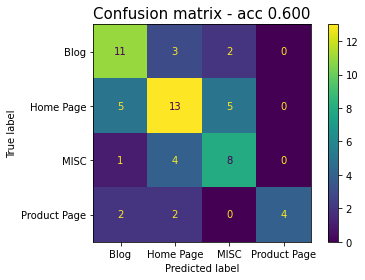


              precision    recall  f1-score   support

        Blog       0.58      0.69      0.63        16
   Home Page       0.59      0.57      0.58        23
        MISC       0.53      0.62      0.57        13
Product Page       1.00      0.50      0.67         8

    accuracy                           0.60        60
   macro avg       0.68      0.59      0.61        60
weighted avg       0.63      0.60      0.60        60



In [125]:
# clf = fit_model(KNeighborsClassifier(n_neighbors=5
#                                       ), 
#                 X_train_tr, 
#                 y_train)

# y_pred = predict(clf, X_test_tr)

# print_confusion_matrix(y_test, y_pred, with_report=True)